# Simple simple simple time series prediction with sequence-to-sequence RNN networks
Michael Nolan, 2020.06.04

I can, for sure, see most of these dependencies being removed.

In [13]:
from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import csv
from itertools import product, combinations

import pickle as pkl

import argparse
import matplotlib.pyplot as plt
from matplotlib import gridspec

### A basic, basic example: sinusoid prediction.
Take 20 points of sample data, predict the next 20 points of that signal.

To do that, we need sinusoid data. Let's make a dataloader that: 
 - for `n_win` windows, generate `m`-dimensional sinusoid with random starting phases, amplitudes
 - splits that data into source/target

In [3]:
class SinDataset(Dataset):
    def __init__(self, freq, dt=0.1, n_ch=2, n_src=20, n_trg=20, amp=0.9):
#         if islist()
        self.freq = freq
        self.amp = amp
        self.dt = dt
        self.n_ch = n_ch
        self.n_src = n_src
        self.n_trg = n_trg

    def __len__(self):
        return self.n_src + self.n_trg

    def __getitem__(self,idx):
        t_out = np.arange(self.n_src+self.n_trg)*self.dt
        data_out = np.zeros((self.n_src+self.n_trg,self.n_ch),dtype=np.float32)
        for k in range(self.n_ch):
            data_out[:,k] = self.amp*np.cos(2*np.pi*self.freq*t_out + np.random.rand()*2*np.pi)
        src = data_out[:self.n_src,:]
        trg = data_out[self.n_src:,:]
        return src, trg

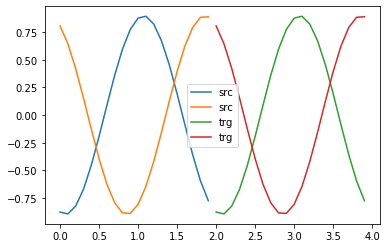

In [4]:
# try it out
test_ds = SinDataset(freq=0.5)
src, trg = test_ds.__getitem__(0)
src_idx = np.arange(test_ds.n_src)
trg_idx = np.arange(test_ds.n_trg) + test_ds.n_src
f,ax = plt.subplots(1,1)
ax.plot(src_idx*test_ds.dt,src, label='src')
ax.plot(trg_idx*test_ds.dt,trg, label='trg')
ax.legend(loc=0)

Yay, that worked. Now let's set up a dataloader that pulls src/trg pairs from the dataset object.

In [5]:
sin_sampler = SequentialSampler(range(20))
batch_size = 1
sin_loader = DataLoader(test_ds,batch_size=batch_size,sampler=sin_sampler)

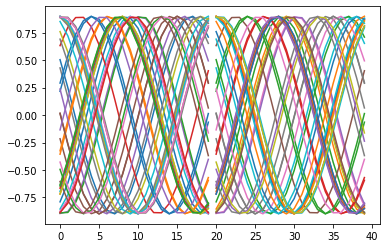

In [6]:
# let's try using that now
f,ax = plt.subplots(1,1)
for src,trg in sin_loader:
    ax.plot(src_idx,src.squeeze(0))
    ax.plot(trg_idx,trg.squeeze(0))

Great! Now we have a working dataloader/sampler as well. I'll have to explicity run some plots during evaluation so show that the network is training. Maybe.

NOW let's draw up a simple (not many layers) seq2seq network and get to training.

In [7]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):

    model.train()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len
    n_ch = model.decoder.output_dim

    for i, (src,trg) in enumerate(iterator):
        if np.mod(i+1,1000) == 0:
            print(i,len(iterator))
#         src = batch[:,:enc_len,:]
#         trg = batch[:,enc_len:enc_len+dec_len,:n_ch] # only train to
        if dec_len == 1:
            trg = trg.unsqueeze(1)

        optimizer.zero_grad()
        output, _, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)

        #trg = [batch size, trg len, output dim]
        #output = [batch size, trg len, output dim]

        loss = criterion(output, trg)
        loss.backward()

        # clipping the gradient norm may not be very helpful...
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        
        # compute loss
        epoch_loss += loss.item()
        batch_loss.append(loss.item())

#         bar.update(10*i/10000)

#         if i > 10000:
#             break

    return epoch_loss, np.array(batch_loss)

In [8]:
def evaluate(model, iterator, criterion, plot_flag=False):

    model.eval()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len

    n_ch = model.decoder.output_dim # rename to *_dim?
    n_h_ch = model.encoder.hid_dim

    batch_size = iterator.batch_size

    with torch.no_grad():
#         widgets = [pb.Percentage(), progressbar.Bar()]
#         bar = pb.ProgressBar(widgets=widgets).start()
#         i = 0
        if plot_flag:
            src_ = torch.zeros(len(iterator),enc_len,n_ch)
            src_dx_ = torch.zeros(len(iterator),enc_len,n_ch)
            trg_ = torch.zeros(len(iterator),dec_len,n_ch)
            out_ = torch.zeros(len(iterator),dec_len,n_ch)
            enc_ = torch.zeros(len(iterator),enc_len,n_h_ch)
            dec_ = torch.zeros(len(iterator),dec_len,n_h_ch)

        for i, (src,trg) in enumerate(iterator):

            if np.mod(i+1,1000)==0:
                print(i,len(iterator))
            if dec_len == 1:
                trg = trg.unsqueeze(1)

            output, enc_state, dec_state = model(src, trg, teacher_forcing_ratio=0.) #turn off teacher forcing
            if plot_flag:
                src_[i,] = src[:,:,:n_ch]
                if src.shape[-1] > n_ch:
                    src_dx_[i,] = src[:,:,n_ch:]
                else:
                    src_dx_[i,] = 0. # works?
                trg_[i,] = trg
                out_[i,] = output
                enc_[i,] = enc_state
                dec_[i,] = dec_state

            #trg = [batch size, trg len]
            #output = [batch size, trg len, output dim]

            output_dim = output.shape[-1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            batch_loss.append(loss.item())

        plot_output = []
        if plot_flag:
            # print('num batch:\t{}'.format(num_batch))
            # print(src.size(),trg.size(),output.size())
            for k in range(len(src_)):
                plot_output.append((src_[k,],src_dx_[k,],trg_[k,],out_[k,],enc_[k,],dec_[k,]))

    # there may be a bug in the loss normalization here
    return epoch_loss, np.array(batch_loss), plot_output

In [9]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [78]:
freq = 0.5
n_ch = 1
n_src = 20
n_trg = 50
test_ds = SinDataset(freq=freq,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_units = 3
n_layers = 1
dropout = np.float32(0.0)
enc = Encoder.Encoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_src, dropout)
dec = Decoder.Decoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_trg, dropout)

model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
model.apply(Util.init_weights) # initialize the model each time.

print(f'The model has {Util.count_parameters(model):,} trainable parameters')

LOSS_OBJ = 'L2'
criterion = Training.ECOGLoss(objective=LOSS_OBJ)

l_rate = 0.001 # default
optimizer = optim.Adam(model.parameters(),lr=l_rate)

The model has 112 trainable parameters


In [10]:
from mpl_toolkits.mplot3d import Axes3D
def plot_current_model_output(model,dataset,file_name=None,figsize=(8,10),plot_hidden_states=False):
    # get a sample
    src,trg = dataset.__getitem__(0)
    src = torch.tensor(src).unsqueeze(0)
    trg = torch.tensor(trg).unsqueeze(0)
    # produce an estimate
    out,enc,dec = model.forward(src,trg,teacher_forcing_ratio=0.0)
    out = out.detach().numpy()
    enc = enc.detach().numpy()
    dec = dec.detach().numpy()
    src_idx = np.arange(test_ds.n_src)
    trg_idx = np.arange(test_ds.n_trg) + test_ds.n_src
    # plot outputs
    n_ch = src.shape[-1]
    n_hid = enc.shape[-1]
    n_oc = np.min((2,n_ch))
    n_or = math.ceil(n_ch/n_oc)
    n_h = enc.shape[-1]
    n_hc = np.min((n_h,3))
    n_hr = math.ceil(n_h/n_hc)
#     f_out,ax = plt.subplots(n_r,n_c,figsize=(10,6*n_r),constrained_layout=True,squeeze=False)
    f_out = plt.figure(figsize=figsize,tight_layout=True,dpi=100)
    if plot_hidden_states:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[0:3])
        gs_hid = gridspec.GridSpecFromSubplotSpec(n_hr,n_hc,subplot_spec=gs[3:])
    else:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[:])
    # input/output
    for k in range(n_ch):
        ax = f.add_subplot(gs_out[k//n_oc,k%n_oc])
        ax.plot(src_idx,src[0,:,k],'k',label='src')
        ax.plot(trg_idx,trg[0,:,k],'k',label='trg')
        ax.plot(trg_idx,out[0,:,k],'ro--',label='out')
        ax.set_title('ch. {}'.format(k))
        if k == 0:
            ax.legend(loc=0)
    if plot_hidden_states:
        # hidden space
        hid_dim_pair_list = list(combinations(np.arange(n_h),2))
        n_hid_dim_pair = len(hid_dim_pair_list)
        for hd_idx in range(n_hid_dim_pair):
            r_idx = hd_idx//n_hc
            c_idx = hd_idx%n_hc
            hd1, hd2 = hid_dim_pair_list[hd_idx]
            h_ax = f.add_subplot(gs_hid[r_idx,c_idx])
            h_ax.plot(enc[0,:,hd1],enc[0,:,hd2],color='g',label='enc')
            h_ax.plot([enc[0,-1,hd1],dec[0,0,hd1]],[enc[0,-1,hd2],dec[0,0,hd2]],color='k')
            h_ax.plot(dec[0,:,hd1],dec[0,:,hd2],color='m',label='dec')
            h_ax.set_title('$h_{}$, $h_{}$'.format(hd1,hd2))
            if hd_idx == 0:
                h_ax.legend(loc=0)
    if file_name != None:
        f.savefig(file_name)
    return f_out

In [144]:
# train the model over a few epochs, check that the loss is decreasing for both train, test sets.
n_epoch = 1000
n_train = 20
n_test = 20
batch_size=200

plot_step = 10

train_loss = []
test_loss = []
print_progress_bar(0, n_epoch, status='')
fig_save_dir = './slow_down_be_simple/'
if not os.path.exists(fig_save_dir):
    os.makedirs(fig_save_dir)
for ep in range(n_epoch):
    if ep % plot_step == 0:
        # plot current prediction behavior
        fig_file_name = os.path.join(fig_save_dir,'ep{}.png'.format(ep))
        model_state_file_name = os.path.join(fig_save_dir,'ep{}.pt'.format(ep))
        f = plot_current_model_output(model,test_ds,file_name=fig_file_name)
        torch.save(model.state_dict(),model_state_file_name)
        plt.close(f)
    train_sampler = SequentialSampler(range(n_train))
    train_loader = DataLoader(test_ds,batch_size=batch_size,sampler=train_sampler)
    test_sampler = SequentialSampler(range(n_test))
    test_loader = DataLoader(test_ds,batch_size=batch_size,sampler=test_sampler)
    trl, _ = train(model, train_loader, optimizer, criterion, clip=np.float32(1.0), teacher_forcing_ratio=np.float32(0.0))
    tel, _, _ = evaluate(model, test_loader, criterion)
    train_loss.append(trl/batch_size) # normalize the 
    test_loss.append(tel/batch_size)
    print_progress_bar(ep+1, n_epoch, status='')

KeyboardInterrupt: 

Min Loss:
Training Data:	0.00891\Test Data:	0.00865


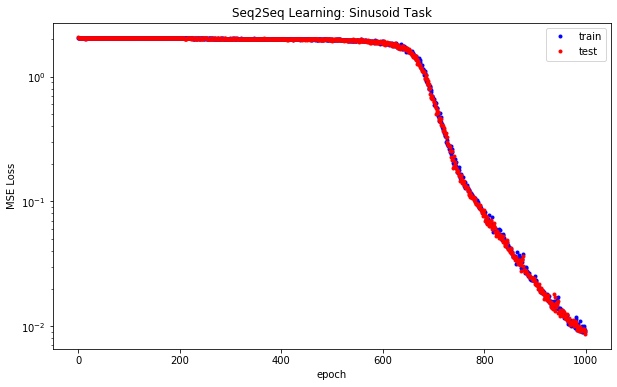

In [81]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(train_loss,'b.',label='train')
ax.plot(test_loss,'r.',label='test')
ax.set_yscale('log')
ax.legend(loc=0)
ax.set_xlabel('epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Seq2Seq Learning: Sinusoid Task')
print('Min Loss:\nTraining Data:\t{:05.3g}\Test Data:\t{:05.3g}'.format(np.min(train_loss),np.min(test_loss)))

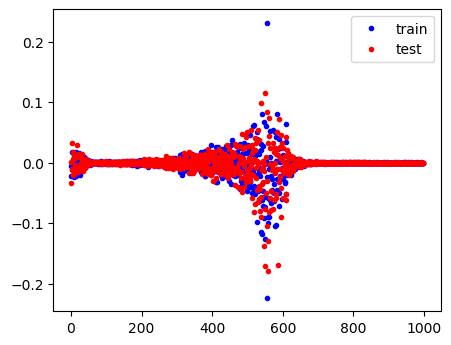

In [72]:
f_diff,ax = plt.subplots(1,1,figsize=(5,4),dpi=100)
ax.plot(np.diff(train_loss),'b.',label='train')
ax.plot(np.diff(test_loss),'r.',label='test')
ax.legend(loc=0)

Oh thank god. It works, for both the train and test data!

...for one frequency and 2 channels. Not bad! 

Now let's see if the network can generalize to a few more frequencies and channel counts. It's also worth exploring adding a few different frequency modes into each channel. Random amplitudes, random relative contributions, etc.

I think that the overall lesson here will be that you need more units to get more frequency modes and to accommodate for more variance. It may be necessary/smart to encode the data into spectral representations that separate different frequency bands into different channels.

NOTE - repeated experimentation has shown me that signal frequency content is very important here. Increasing the signal frequency to near-nyquist makes for a harder prediction task. This is very interesting - Maybe I shouldn't be downsampling so much in the ECoG data! Also, I'll have to loop over all the different parameters here to see what patterns there are in model performance.

In [15]:
# note: this will only work for a single layer, as-is.
def split_seq2seq_param_matrices(model_dict):
    ## encoder
    _,n_u_enc = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_e = model_dict['encoder.rnn.weight_ih_l0'][:n_u_enc,]
    W_iz_e = model_dict['encoder.rnn.weight_ih_l0'][n_u_enc:2*n_u_enc,]
    W_in_e = model_dict['encoder.rnn.weight_ih_l0'][2*n_u_enc:3*n_u_enc,]
    b_ir_e = model_dict['encoder.rnn.bias_ih_l0'][:n_u_enc,]
    b_iz_e = model_dict['encoder.rnn.bias_ih_l0'][n_u_enc:2*n_u_enc,]
    b_in_e = model_dict['encoder.rnn.bias_ih_l0'][2*n_u_enc:3*n_u_enc,]
    # h -> h
    W_hr_e = model_dict['encoder.rnn.weight_hh_l0'][:n_u_enc,]
    W_hz_e = model_dict['encoder.rnn.weight_hh_l0'][n_u_enc:2*n_u_enc,]
    W_hn_e = model_dict['encoder.rnn.weight_hh_l0'][2*n_u_enc:3*n_u_enc,]
    b_hr_e = model_dict['encoder.rnn.bias_hh_l0'][:n_u_enc,]
    b_hz_e = model_dict['encoder.rnn.bias_hh_l0'][n_u_enc:2*n_u_enc,]
    b_hn_e = model_dict['encoder.rnn.bias_hh_l0'][2*n_u_enc:3*n_u_enc,]
    ## decoder
    _,n_u_dec = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_d = model_dict['decoder.rnn.weight_ih_l0'][:n_u_dec,]
    W_iz_d = model_dict['decoder.rnn.weight_ih_l0'][n_u_dec:2*n_u_dec,]
    W_in_d = model_dict['decoder.rnn.weight_ih_l0'][2*n_u_dec:3*n_u_dec,]
    b_ir_d = model_dict['decoder.rnn.bias_ih_l0'][:n_u_dec,]
    b_iz_d = model_dict['decoder.rnn.bias_ih_l0'][n_u_dec:2*n_u_dec,]
    b_in_d = model_dict['decoder.rnn.bias_ih_l0'][2*n_u_dec:3*n_u_dec,]
    # h -> h
    W_hr_d = model_dict['decoder.rnn.weight_hh_l0'][:n_u_dec,]
    W_hz_d = model_dict['decoder.rnn.weight_hh_l0'][n_u_dec:2*n_u_dec,]
    W_hn_d = model_dict['decoder.rnn.weight_hh_l0'][2*n_u_dec:3*n_u_dec,]
    b_hr_d = model_dict['decoder.rnn.bias_hh_l0'][:n_u_dec,]
    b_hz_d = model_dict['decoder.rnn.bias_hh_l0'][n_u_dec:2*n_u_dec,]
    b_hn_d = model_dict['decoder.rnn.bias_hh_l0'][2*n_u_dec:3*n_u_dec,]
    # fc linear out
    W_fc_d = model_dict['decoder.fc_out.weight']
    b_fc_d = model_dict['decoder.fc_out.bias']
    ## collect into dict
    param_dict = {
        'encoder' : {
            # i -> h
            'Wir' : W_ir_e,
            'Wiz' : W_iz_e,
            'Win' : W_in_e,
            'bir' : b_ir_e,
            'biz' : b_iz_e,
            'bin' : b_in_e,
            # h -> h
            'Whr' : W_hr_e,
            'Whz' : W_hz_e,
            'Whn' : W_hn_e,
            'bhr' : b_hr_e,
            'bhz' : b_hz_e,
            'bhn' : b_hn_e
        },
        'decoder' : {
            # i -> h
            'Wir' : W_ir_d,
            'Wiz' : W_iz_d,
            'Win' : W_in_d,
            'bir' : b_ir_d,
            'biz' : b_iz_d,
            'bin' : b_in_d,
            # h -> h
            'Whr' : W_hr_d,
            'Whz' : W_hz_d,
            'Whn' : W_hn_d,
            'bhr' : b_hr_d,
            'bhz' : b_hz_d,
            'bhn' : b_hn_d,
            # h -> o
            'Wfc' : W_fc_d,
            'bfc' : b_fc_d
        }
    }
    return param_dict

In [16]:
def compute_param_diff_dict(param_dict_1,param_dict_2):
    # computes the kv-wise difference in parameter values between parameter dicts in left-right order.
    param_diff = param_dict_1.copy()
    block_str_list = param_diff.keys()
    for block_str in block_str_list:
        param_str_list = param_diff[block_str].keys()
        for param_str in param_str_list:
            param_diff[block_str][param_str] = param_dict_1[block_str][param_str] - param_dict_2[block_str][param_str]
    return param_diff

In [17]:
from matplotlib import gridspec
def plot_seq2seq_params(param_dict,cmap=plt.cm.seismic,figsize=(20,10)):
    ## plots a full schematic of all network parameter values for a seq2seq recurrent model.
    # if I can find a smart way of iterating through the parameterization, I'll have to implement that.
    # in the meantime, it's spaghetti dinner.
    
    # create figure, axes from gridspec
    f_params = plt.figure(constrained_layout=True,figsize=figsize)
    gs = gridspec.GridSpec(1,2)
    enc_gs = gs[0].subgridspec(4,10)
    dec_gs = gs[1].subgridspec(4,10)
    # define colormap
    max_val = np.concatenate([[param_dict[rnn][param].max().item() for param in param_dict[rnn].keys()] for rnn in param_dict.keys()]).max()
    min_val = np.concatenate([[param_dict[rnn][param].min().item() for param in param_dict[rnn].keys()] for rnn in param_dict.keys()]).min()
    im_norm = plt.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(cmap=cmap,norm=im_norm)
    # encoder parameters
    ax_Wir_enc = f_params.add_subplot(enc_gs[0,:4])
    ax_bir_enc = f_params.add_subplot(enc_gs[0,4])
    ax_Whr_enc = f_params.add_subplot(enc_gs[0,5:9])
    ax_bhr_enc = f_params.add_subplot(enc_gs[0,9])
    ax_Wiz_enc = f_params.add_subplot(enc_gs[1,:4])
    ax_biz_enc = f_params.add_subplot(enc_gs[1,4])
    ax_Whz_enc = f_params.add_subplot(enc_gs[1,5:9])
    ax_bhz_enc = f_params.add_subplot(enc_gs[1,9])
    ax_Win_enc = f_params.add_subplot(enc_gs[2,:4])
    ax_bin_enc = f_params.add_subplot(enc_gs[2,4])
    ax_Whn_enc = f_params.add_subplot(enc_gs[2,5:9])
    ax_bhn_enc = f_params.add_subplot(enc_gs[2,9])
    # decoder_parameters
    ax_Wir_dec = f_params.add_subplot(dec_gs[0,:4])
    ax_bir_dec = f_params.add_subplot(dec_gs[0,4])
    ax_Whr_dec = f_params.add_subplot(dec_gs[0,5:9])
    ax_bhr_dec = f_params.add_subplot(dec_gs[0,9])
    ax_Wiz_dec = f_params.add_subplot(dec_gs[1,:4])
    ax_biz_dec = f_params.add_subplot(dec_gs[1,4])
    ax_Whz_dec = f_params.add_subplot(dec_gs[1,5:9])
    ax_bhz_dec = f_params.add_subplot(dec_gs[1,9])
    ax_Win_dec = f_params.add_subplot(dec_gs[2,:4])
    ax_bin_dec = f_params.add_subplot(dec_gs[2,4])
    ax_Whn_dec = f_params.add_subplot(dec_gs[2,5:9])
    ax_bhn_dec = f_params.add_subplot(dec_gs[2,9])
    ax_Wfc_dec = f_params.add_subplot(dec_gs[3,:4])
    ax_bfc_dec = f_params.add_subplot(dec_gs[3,4])
    # colorbar
#     ax_cb = f_params.add_subplot(enc_gs[3,5:9])
#     ax_cb = ax_Whn_enc.append_axes("bottom", size="10%")#, pad=0.05)
    ax_cb = f_params.add_axes([0.52, 0.5, 0.01, 0.2])
    
    # plot parameter heatmaps
    # encoder
    ax_Wir_enc.imshow(param_dict['encoder']['Wir'],cmap=cmap,norm=im_norm)
    ax_Wir_enc.set_title('Encoder\n$W_{ir}$')
    ax_bir_enc.imshow(param_dict['encoder']['bir'][:,None],cmap=cmap,norm=im_norm)
    ax_bir_enc.set_title('$b_{ir}$')
    ax_Whr_enc.imshow(param_dict['encoder']['Whr'],cmap=cmap,norm=im_norm)
    ax_Whr_enc.set_title('$W_{hr}$')
    ax_bhr_enc.imshow(param_dict['encoder']['bhr'][:,None],cmap=cmap,norm=im_norm)
    ax_bhr_enc.set_title('$b_{hr}$')
    ax_Wiz_enc.imshow(param_dict['encoder']['Wiz'],cmap=cmap,norm=im_norm)
    ax_Wiz_enc.set_title('$W_{iz}$')
    ax_biz_enc.imshow(param_dict['encoder']['biz'][:,None],cmap=cmap,norm=im_norm)
    ax_biz_enc.set_title('$b_{iz}$')
    ax_Whz_enc.imshow(param_dict['encoder']['Whz'],cmap=cmap,norm=im_norm)
    ax_Whz_enc.set_title('$W_{hz}$')
    ax_bhz_enc.imshow(param_dict['encoder']['bhz'][:,None],cmap=cmap,norm=im_norm)
    ax_bhz_enc.set_title('$b_{hz}$')
    ax_Win_enc.imshow(param_dict['encoder']['Win'],cmap=cmap,norm=im_norm)
    ax_Win_enc.set_title('$W_{in}$')
    ax_bin_enc.imshow(param_dict['encoder']['bin'][:,None],cmap=cmap,norm=im_norm)
    ax_bin_enc.set_title('$b_{in}$')
    ax_Whn_enc.imshow(param_dict['encoder']['Whn'],cmap=cmap,norm=im_norm)
    ax_Whn_enc.set_title('$W_{hn}$')
    ax_bhn_enc.imshow(param_dict['encoder']['bhn'][:,None],cmap=cmap,norm=im_norm)
    ax_bhn_enc.set_title('$b_{hn}$')
    # decoder
    ax_Wir_dec.imshow(param_dict['decoder']['Wir'],cmap=cmap,norm=im_norm)
    ax_Wir_dec.set_title('Decoder\n$W_{ir}$')
    ax_bir_dec.imshow(param_dict['decoder']['bir'][:,None],cmap=cmap,norm=im_norm)
    ax_bir_dec.set_title('$b_{ir}$')
    ax_Whr_dec.imshow(param_dict['decoder']['Whr'],cmap=cmap,norm=im_norm)
    ax_Whr_dec.set_title('$W_{hr}$')
    ax_bhr_dec.imshow(param_dict['decoder']['bhr'][:,None],cmap=cmap,norm=im_norm)
    ax_bhr_dec.set_title('$b_{hr}$')
    ax_Wiz_dec.imshow(param_dict['decoder']['Wiz'],cmap=cmap,norm=im_norm)
    ax_Wiz_dec.set_title('$W_{iz}$')
    ax_biz_dec.imshow(param_dict['decoder']['biz'][:,None],cmap=cmap,norm=im_norm)
    ax_biz_dec.set_title('$b_{iz}$')
    ax_Whz_dec.imshow(param_dict['decoder']['Whz'],cmap=cmap,norm=im_norm)
    ax_Whz_dec.set_title('$W_{hz}$')
    ax_bhz_dec.imshow(param_dict['decoder']['bhz'][:,None],cmap=cmap,norm=im_norm)
    ax_bhz_dec.set_title('$b_{hz}$')
    ax_Win_dec.imshow(param_dict['decoder']['Win'],cmap=cmap,norm=im_norm)
    ax_Win_dec.set_title('$W_{in}$')
    ax_bin_dec.imshow(param_dict['decoder']['bin'][:,None],cmap=cmap,norm=im_norm)
    ax_bin_dec.set_title('$b_{in}$')
    ax_Whn_dec.imshow(param_dict['decoder']['Whn'],cmap=cmap,norm=im_norm)
    ax_Whn_dec.set_title('$W_{hn}$')
    ax_bhn_dec.imshow(param_dict['decoder']['bhn'][:,None],cmap=cmap,norm=im_norm)
    ax_bhn_dec.set_title('$b_{hn}$')
    ax_Wfc_dec.imshow(param_dict['decoder']['Wfc'],cmap=cmap,norm=im_norm)
    ax_Wfc_dec.set_title('$W_{fc}$')
    ax_bfc_dec.imshow(param_dict['decoder']['bfc'][:,None],cmap=cmap,norm=im_norm)
    ax_bfc_dec.set_title('$b_{fc}$')
    
    # colorbar
    cb = plt.colorbar(scalar_map,cax=ax_cb,orientation='vertical')
    cb.set_label('amplitude')
    
    # adjust axes
    [ax.axis('off') for ax in f_params.axes[:-1]]
    
    return f_params

In [18]:
def plot_matrix(X,name='',cmap=plt.cm.seismic,n_ev=3):
    
    # compute SVD
    u,s,v = sp.linalg.svd(X)
    ev = s**2
    nsev = np.cumsum(ev)/ev.sum()
    
    # make figure, axes, mappables
    f_mat,ax = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
    max_val = X.max().item()
    min_val = X.min().item()
    im_norm = plt.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(cmap=cmap,norm=im_norm)
    left_cm_f = plt.cm.Greens
    right_cm_f = plt.cm.Purples
    left_cm = left_cm_f(np.linspace(1,0.4,n_ev))
    right_cm = right_cm_f(np.linspace(1,0.4,n_ev))
    
    # image itself
    ax[0,0].imshow(X,cmap=cmap,norm=im_norm)
    ax[0,0].set_title('{} $= U\Sigma V^T$'.format(name))
    plt.colorbar(scalar_map,ax=ax[0,0])
    
    # singular values, cumsum
    ax[0,1].plot(ev,color='tab:blue')
    ax[0,1].set_ylabel('eigenvalue',color='tab:blue')
    ax12 = ax[0,1].twinx()
    ax12.plot(nsev,color='tab:red')
    ax12.axvline(n_ev-1,color='gray')
    ax12.axhline(nsev[n_ev-1],color='gray')
    ax12.text(n_ev-1,nsev[n_ev-1],'(num_ev = {}, {:05.3f})'.format(n_ev,nsev[n_ev-1]),verticalalignment='top')
    ax12.set_ylim([-0.05,1.05])
    ax12.set_ylabel('norm. e.v. sum',color='tab:red')
    ax[0,1].set_title('$\sigma^2$ spectrum')
    
    # left, right eigenvectors (u)
    offset_y = np.arange(n_ev)*0.3
    for k in range(n_ev):
        ax[1,0].plot(offset_y[k] + u[:,k],color=left_cm[k])
        ax[1,1].plot(offset_y[k] + v[:,k],color=right_cm[k])
    ax[1,0].set_title('$U$'.format(n_ev-1))
    ax[1,0].set_yticks(ticks=offset_y)
    ax[1,0].set_yticklabels(labels=range(n_ev))
    ax[1,1].set_title('$V$'.format(n_ev-1))
    ax[1,1].set_yticks(ticks=offset_y)
    ax[1,1].set_yticklabels(labels=range(n_ev))
    
    return f_mat,ax

In [11]:
# train models over different frequencies, see the effect on training and hidden state activity
nyquist_freq = 1/test_ds.dt/2
test_freq = [0.1, 0.2, 0.5, 1.0, 2.0, 4.0]

The model has 202 trainable parameters

0.1 Hz:



/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.


Min Loss:====================================================] 100.0% ...
Training Data:	01.63\Test Data:	01.69
The model has 202 trainable parameters

0.2 Hz:

Min Loss:====================================================] 100.0% ...
Training Data:	001.7\Test Data:	01.69
The model has 202 trainable parameters

0.5 Hz:

Min Loss:====================================================] 100.0% ...
Training Data:	0.453\Test Data:	0.446
The model has 202 trainable parameters

1.0 Hz:

Min Loss:====================================================] 100.0% ...
Training Data:	01.78\Test Data:	01.49
The model has 202 trainable parameters

2.0 Hz:

Min Loss:====================================================] 100.0% ...
Training Data:	01.68\Test Data:	01.46
The model has 202 trainable parameters

4.0 Hz:

Min Loss:====================================================] 100.0% ...
Training Data:	01.68\Test Data:	01.69


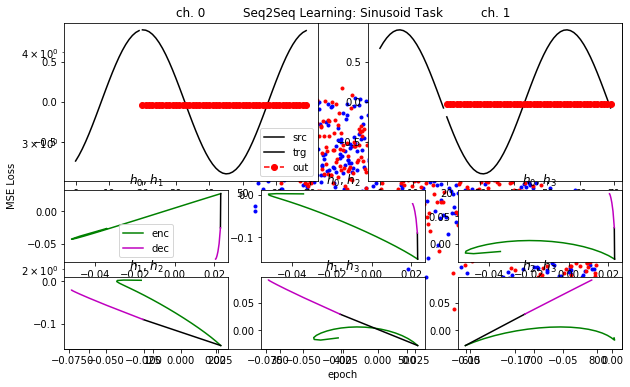

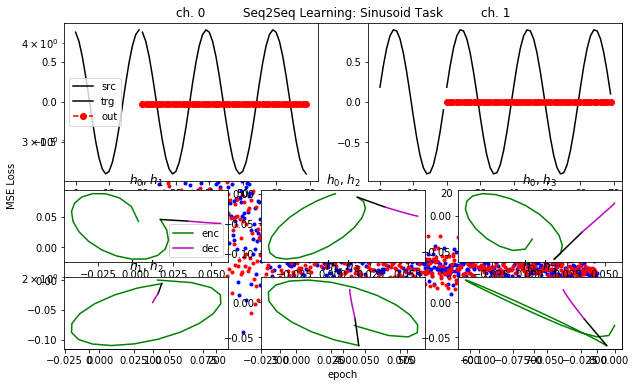

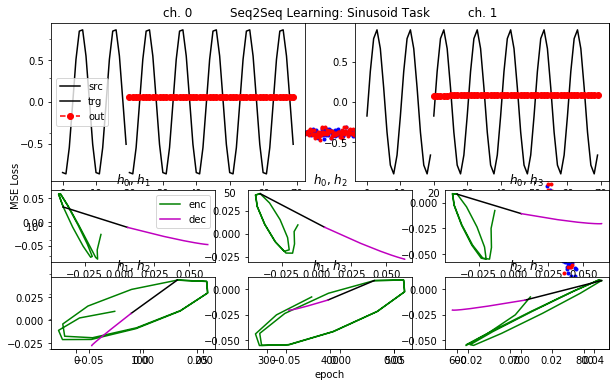

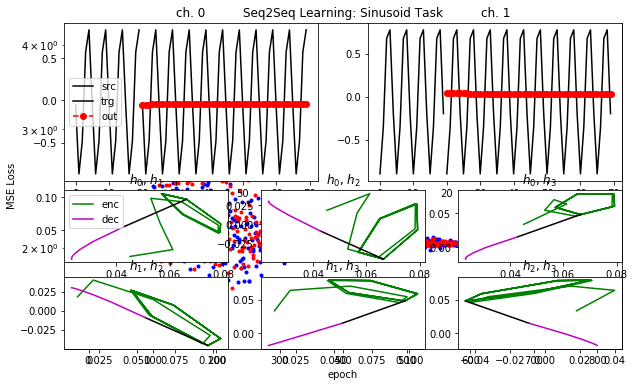

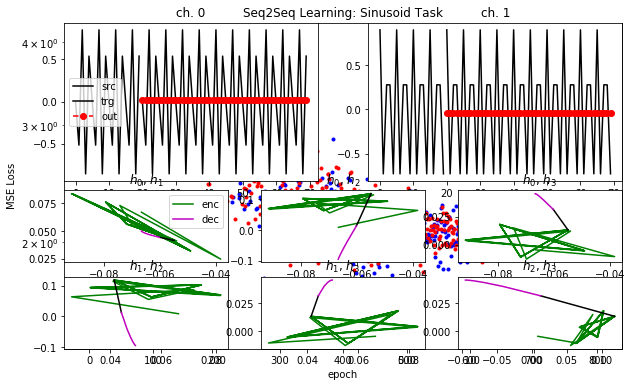

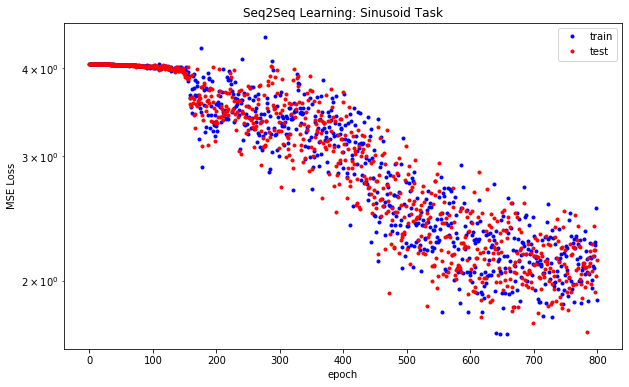

In [148]:
# single/multi channel test
n_ch = 2
n_src = 20
n_trg = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_units = 4
n_layers = 1
dropout = np.float32(0.0)
LOSS_OBJ = 'L2'
l_rate = 0.005 # 5*default

n_epoch = 800
n_train = 20
n_test = 20
batch_size=200
plot_step = 10

train_loss_all = []
test_loss_all = []

plt.close('all')
result_save_path = '/Volumes/Samsung_T5/seq2seq_dev/sin_test/freqsweep_{}ch_{}hid'.format(n_ch,n_units) # find a place on the drive to put these
for freq in test_freq:
    # create dataset
    test_ds = SinDataset(freq=freq,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz
    # create new model
    enc = Encoder.Encoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_src, dropout)
    dec = Decoder.Decoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_trg, dropout)
    model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
    model.apply(Util.init_weights) # initialize the model each time.
    print(f'The model has {Util.count_parameters(model):,} trainable parameters')
    criterion = Training.ECOGLoss(objective=LOSS_OBJ)
    optimizer = optim.Adam(model.parameters(),lr=l_rate)
    # train it
    train_loss = []
    test_loss = []
    print('\n{} Hz:\n'.format(freq))
    print_progress_bar(0, n_epoch, status='')
    fig_save_dir = os.path.join(result_save_path,'freq_{:0.1f}'.format(freq))
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    for ep in range(n_epoch):
        if ep % plot_step == 0:
            # plot current prediction behavior
            fig_file_name = os.path.join(fig_save_dir,'ep{}.png'.format(ep))
            model_state_file_name = os.path.join(fig_save_dir,'ep{}.pt'.format(ep))
            f = plot_current_model_output(model,test_ds,file_name=fig_file_name,figsize=(12,10))
            torch.save(model.state_dict(),model_state_file_name)
            plt.close(f)
        train_sampler = SequentialSampler(range(n_train))
        train_loader = DataLoader(test_ds,batch_size=batch_size,sampler=train_sampler)
        test_sampler = SequentialSampler(range(n_test))
        test_loader = DataLoader(test_ds,batch_size=batch_size,sampler=test_sampler)
        trl, _ = train(model, train_loader, optimizer, criterion, clip=np.float32(1.0), teacher_forcing_ratio=np.float32(0.0))
        tel, _, _ = evaluate(model, test_loader, criterion)
        train_loss.append(trl/batch_size) # normalize the 
        test_loss.append(tel/batch_size)
        print_progress_bar(ep+1, n_epoch, status='')
    train_loss_all.append(train_loss)
    test_loss_all.append(test_loss)
    # save loss curves
    f,ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(train_loss,'b.',label='train')
    ax.plot(test_loss,'r.',label='test')
    ax.set_yscale('log')
    ax.legend(loc=0)
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Seq2Seq Learning: Sinusoid Task')
    print('Min Loss:\nTraining Data:\t{:05.3g}\Test Data:\t{:05.3g}'.format(np.min(train_loss),np.min(test_loss)))
    f.savefig(os.path.join(fig_save_dir,'loss_curve_{:0.1f}.png'.format(freq)))

In [ ]:
# single/multi channel test
n_ch = 2
n_src = 20
n_trg = 50
freq = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_unit_list = np.arange(3,10)
n_layers = 1
dropout = np.float32(0.0)
LOSS_OBJ = 'L2'
l_rate = 0.005 # 5*default

n_epoch = 800
n_train = 20
n_test = 20
batch_size=200
plot_step = 10

train_loss_all = []
test_loss_all = []

plt.close('all')
result_save_path = '/Volumes/Samsung_T5/seq2seq_dev/sin_test/husweep_{}ch_{}hz'.format(n_ch,freq) # find a place on the drive to put these
for n_units in n_unit_list:
    # create dataset
    test_ds = SinDataset(freq=freq,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz
    # create new model
    enc = Encoder.Encoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_src, dropout)
    dec = Decoder.Decoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_trg, dropout)
    model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
    model.apply(Util.init_weights) # initialize the model each time.
    print(f'The model has {Util.count_parameters(model):,} trainable parameters')
    criterion = Training.ECOGLoss(objective=LOSS_OBJ)
    optimizer = optim.Adam(model.parameters(),lr=l_rate)
    # train it
    train_loss = []
    test_loss = []
    print('\n{} units:\n'.format(n_units))
    print_progress_bar(0, n_epoch, status='')
    fig_save_dir = os.path.join(result_save_path,'nu_{}'.format(n_units))
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    for ep in range(n_epoch):
        plot_hidden_states = n_units <= 4
        if ep % plot_step == 0:
            # plot current prediction behavior
            fig_file_name = os.path.join(fig_save_dir,'ep{}.png'.format(ep))
            model_state_file_name = os.path.join(fig_save_dir,'ep{}.pt'.format(ep))
            f = plot_current_model_output(model,test_ds,file_name=fig_file_name,figsize=(12,10)
                                          ,plot_hidden_states=plot_hidden_states)
            torch.save(model.state_dict(),model_state_file_name)
            plt.close(f)
        train_sampler = SequentialSampler(range(n_train))
        train_loader = DataLoader(test_ds,batch_size=batch_size,sampler=train_sampler)
        test_sampler = SequentialSampler(range(n_test))
        test_loader = DataLoader(test_ds,batch_size=batch_size,sampler=test_sampler)
        trl, _ = train(model, train_loader, optimizer, criterion, clip=np.float32(1.0), teacher_forcing_ratio=np.float32(0.0))
        tel, _, _ = evaluate(model, test_loader, criterion)
        train_loss.append(trl/batch_size) # normalize the 
        test_loss.append(tel/batch_size)
        print_progress_bar(ep+1, n_epoch, status='')
    train_loss_all.append(train_loss)
    test_loss_all.append(test_loss)
    # save loss curves
    f,ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(train_loss,'b.',label='train')
    ax.plot(test_loss,'r.',label='test')
    ax.set_yscale('log')
    ax.legend(loc=0)
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Seq2Seq Learning: Sinusoid Task')
    print('\nMin Loss:\nTraining Data:\t{:05.3g}\Test Data:\t{:05.3g}'.format(np.min(train_loss),np.min(test_loss)))
    f.savefig(os.path.join(fig_save_dir,'loss_curve_{:0.1f}.png'.format(freq)))

The model has 134 trainable parameters

3 units:

